In [1]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import opinion_lexicon
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
nltk.download('opinion_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


True

In [2]:
# Load the cleaned datasets
reviews = pd.read_parquet('data/review_Cell_Phones_and_Accessories.parquet')
metadata = pd.read_parquet('data/metadata_Cell_Phones_and_Accessories.parquet')

# Merge the datasets on 'asin' and 'parent_asin'
merged_data = pd.merge(reviews, metadata, on=['parent_asin'], how='inner')

# Amazon rating

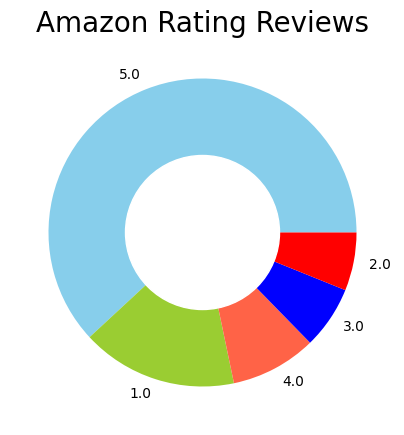

In [3]:
ratings = merged_data["rating"].value_counts()
number = ratings.index
quantity = ratings.values 

custom_colors = ["skyblue", "yellowgreen", 'tomato', "blue", "red"]
plt.figure(figsize=(5, 5))
plt.pie(quantity, labels=number, colors=custom_colors)
central_circle = plt.Circle((0, 0), 0.5, color='white')
fig = plt.gcf()
fig.gca().add_artist(central_circle)
plt.rc('font', size=12)
plt.title("Amazon Rating Reviews", fontsize=20)
plt.show()

# Sentiment distribution for all the reviews

In [15]:
# Sentiment Analysis
sid = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    """Analyze sentiment of the given text."""
    scores = sid.polarity_scores(text)
    return scores['compound']

# Apply sentiment analysis to the review text
merged_data['sentiment_score'] = merged_data['text'].apply(analyze_sentiment)

# Categorize sentiment
merged_data['sentiment_category'] = pd.cut(
    merged_data['sentiment_score'], 
    bins=[-1, -0.1, 0.1, 1], 
    labels=['Negative', 'Neutral', 'Positive']
)

c:\Users\LENOVO\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



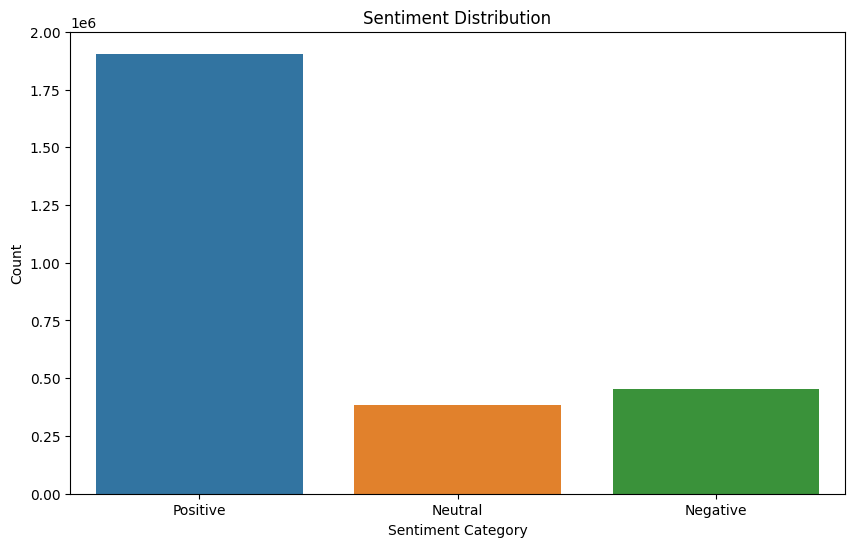

In [16]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(10, 6))
sns.countplot(data=merged_data, x='sentiment_category', order=['Positive', 'Neutral', 'Negative'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.show()

# Word Cloud for Positive and Negative Reviews

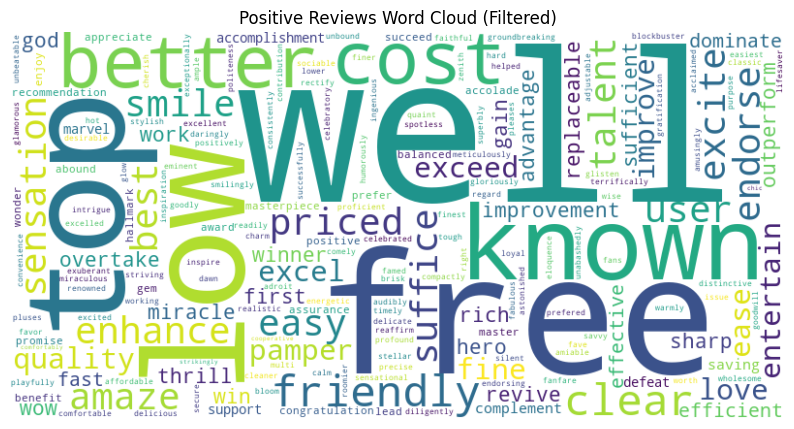

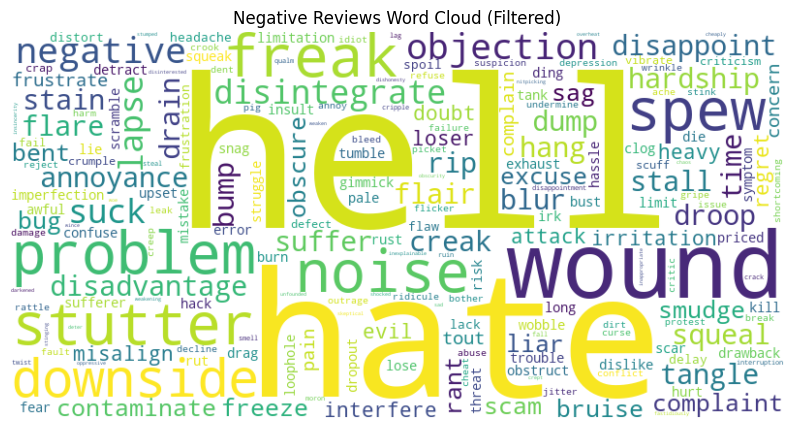

In [20]:
# Get a list of positive and negative words from the lexicon
positive_words_set = set(opinion_lexicon.positive())
negative_words_set = set(opinion_lexicon.negative())

def filter_positive_words_chunked(text_series):
    """Filter unique positive words from a pandas Series in chunks."""
    unique_positive_words = set()
    for text in text_series:
        if pd.isna(text):  # Skip NaN values
            continue
        words = text.split()
        unique_positive_words.update(word.lower() for word in words if word.lower() in positive_words_set)
    return " ".join(unique_positive_words)

def filter_negative_words_chunked(text_series):
    """Filter unique negative words from a pandas Series in chunks."""
    unique_negative_words = set()
    for text in text_series:
        if pd.isna(text):  # Skip NaN values
            continue
        words = text.split()
        unique_negative_words.update(word.lower() for word in words if word.lower() in negative_words_set)
    return " ".join(unique_negative_words)

def plot_wordcloud_filtered(data, sentiment_category, filter_positive=False, filter_negative=False):
    """Generate a word cloud for the specified sentiment category with unique words."""
    text_series = data[data['sentiment_category'] == sentiment_category]['text']
    if filter_positive:
        text = filter_positive_words_chunked(text_series)  # Filter positive words in chunks
    elif filter_negative:
        text = filter_negative_words_chunked(text_series)  # Filter negative words in chunks
    else:
        text = " ".join(text_series.fillna(""))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{sentiment_category} Reviews Word Cloud (Filtered)' if filter_positive or filter_negative else f'{sentiment_category} Reviews Word Cloud')
    plt.show()

# Example Usage
plot_wordcloud_filtered(merged_data, 'Positive', filter_positive=True)  # Unique Positive words only
plot_wordcloud_filtered(merged_data, 'Negative', filter_negative=True)  # Unique Negative words only

# Review classification

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Extract the 'text' column and preprocess
reviews = merged_data['text'].astype(str)
labels = merged_data['sentiment_category']  

# Preprocessing the Text
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and numbers
    text = text.lower()  # Convert to lowercase
    text = text.strip()  # Remove leading/trailing whitespace
    return text

reviews = reviews.apply(clean_text)

# Encode the labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Tokenization and Padding
max_vocab_size = 1000  # Maximum number of words to keep in the tokenizer
max_sequence_length = 100  

tokenizer = Tokenizer(num_words=max_vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(reviews)

word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(reviews)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, encoded_labels, test_size=0.2, random_state=42
)

# Create the Model
embedding_dim = 100

model = Sequential([
    Embedding(input_dim=max_vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
    SpatialDropout1D(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 output classes: positive, neutral, negative
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Train the Model
batch_size = 64
epochs = 5

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=batch_size,
    epochs=epochs,
    verbose=1
)

# Evaluate the Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Predict Sentiments for New Reviews
new_reviews = ["This product is amazing!", "Terrible quality, not recommended.", "It's okay, but not great."]
new_sequences = tokenizer.texts_to_sequences(new_reviews)
new_padded = pad_sequences(new_sequences, maxlen=max_sequence_length, padding='post')
predictions = model.predict(new_padded)

for review, pred in zip(new_reviews, predictions):
    sentiment = label_encoder.inverse_transform([np.argmax(pred)])[0]
    print(f"Review: {review} -> Sentiment: {sentiment}")


C:\Users\LENOVO\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
34282/34282 ━━━━━━━━━━━━━━━━━━━━ 1916s 56ms/step - accuracy: 0.8098 - loss: 0.5217 - val_accuracy: 0.9158 - val_loss: 0.2385
Epoch 2/5
34282/34282 ━━━━━━━━━━━━━━━━━━━━ 2457s 72ms/step - accuracy: 0.9136 - loss: 0.2501 - val_accuracy: 0.9175 - val_loss: 0.2304
Epoch 3/5
34282/34282 ━━━━━━━━━━━━━━━━━━━━ 1469s 43ms/step - accuracy: 0.9153 - loss: 0.2419 - val_accuracy: 0.9193 - val_loss: 0.2255
Epoch 4/5
34282/34282 ━━━━━━━━━━━━━━━━━━━━ 1345s 39ms/step - accuracy: 0.9171 - loss: 0.2367 - val_accuracy: 0.9198 - val_loss: 0.2232
Epoch 5/5
34282/34282 ━━━━━━━━━━━━━━━━━━━━ 1204s 35ms/step - accuracy: 0.9178 - loss: 0.2345 - val_accuracy: 0.9201 - val_loss: 0.2224
17141/17141 ━━━━━━━━━━━━━━━━━━━━ 146s 8ms/step - accuracy: 0.9197 - loss: 0.2226
Test Accuracy: 92.01%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
Review: This product is amazing! -> Sentiment: Positive
Review: Terrible quality, not recommended. -> Sentiment: Negative
Review: It's okay, but not great. -> Sentiment: Negative


85703/85703 ━━━━━━━━━━━━━━━━━━━━ 728s 8ms/step
comparison
Match       2511102
Mismatch     231394
Name: count, dtype: int64


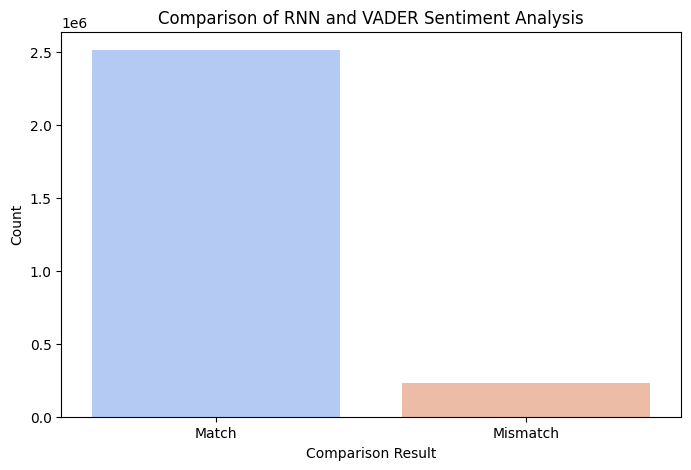

In [6]:
# Step 10: Predict Sentiments with RNN for the Entire Dataset
rnn_sequences = tokenizer.texts_to_sequences(merged_data['text'])
rnn_padded = pad_sequences(rnn_sequences, maxlen=max_sequence_length, padding='post')
rnn_predictions = model.predict(rnn_padded)

# Map RNN predictions to sentiment categories
merged_data['rnn_sentiment_category'] = label_encoder.inverse_transform(np.argmax(rnn_predictions, axis=1))

# Step 11: Compare RNN and VADER Sentiment Categories
merged_data['comparison'] = np.where(
    merged_data['rnn_sentiment_category'] == merged_data['sentiment_category'], 
    'Match', 
    'Mismatch'
)

# Count Matches and Mismatches
comparison_counts = merged_data['comparison'].value_counts()
print(comparison_counts)

# Visualization: Agreement/Disagreement
plt.figure(figsize=(8, 5))
sns.countplot(data=merged_data, x='comparison', palette='coolwarm')
plt.title('Comparison of RNN and VADER Sentiment Analysis')
plt.xlabel('Comparison Result')
plt.ylabel('Count')
plt.show()

# Sentiment distribution for top 12 products (with the highest reviews)

In [13]:
import plotly.express as px

# Prepare data for plotting
def prepare_sentiment_data(products, merged_data, metadata):
    sentiment_data = []
    
    for product_asin in products:
        product_data = merged_data[merged_data['parent_asin'] == product_asin]
        product_title = metadata.loc[metadata['parent_asin'] == product_asin, 'title'].values[0] if not metadata.empty else product_asin
        
        # Count sentiment categories
        sentiment_counts = product_data['sentiment_category'].value_counts()
        
        # Append to the list
        for sentiment, count in sentiment_counts.items():
            sentiment_data.append({
                'Product': product_title,
                'Sentiment Category': sentiment,
                'Count': count
            })
    
    return pd.DataFrame(sentiment_data)

# Prepare data for top products
top_products = merged_data['parent_asin'].value_counts().head(10).index
sentiment_df = prepare_sentiment_data(top_products, merged_data, metadata)

# Create a horizontal stacked bar chart using Plotly
fig = px.bar(
    sentiment_df,
    x='Count',
    y='Product',
    color='Sentiment Category',
    orientation='h',  # Horizontal bar chart
    title='Sentiment Distribution for Top Products',
    labels={'Count': 'Number of Reviews', 'Product': 'Products'},
    color_discrete_sequence=px.colors.qualitative.Set2  
)

# Show the plot
fig.show()


# Top 10 Products with the most Negative Reviews

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10048\3581538710.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_data.groupby(['parent_asin', 'sentiment_category'])


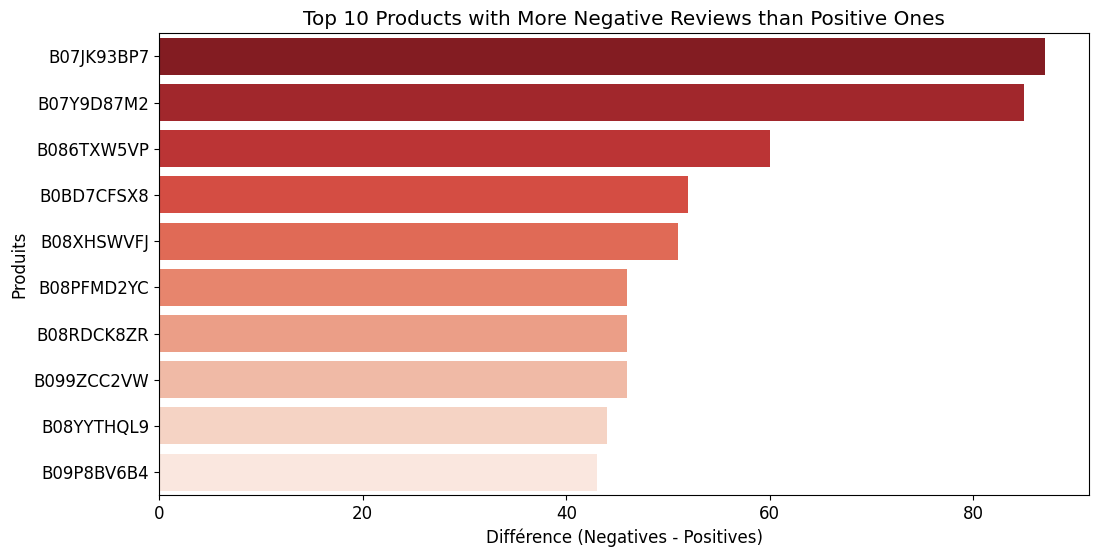

In [10]:
sentiment_counts = (
    merged_data.groupby(['parent_asin', 'sentiment_category'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

sentiment_counts['negative_more_than_positive'] = (
    sentiment_counts.get('Negative', 0) - sentiment_counts.get('Positive', 0)
)

top_negative_products = (
    sentiment_counts.sort_values(by='negative_more_than_positive', ascending=False)
    .head(10)
)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_negative_products,
    x='negative_more_than_positive',
    y='parent_asin',
    palette='Reds_r',
)
plt.title('Top 10 Products with More Negative Reviews than Positive Ones')
plt.xlabel('Différence (Negatives - Positives)')
plt.ylabel('Produits')
plt.show()

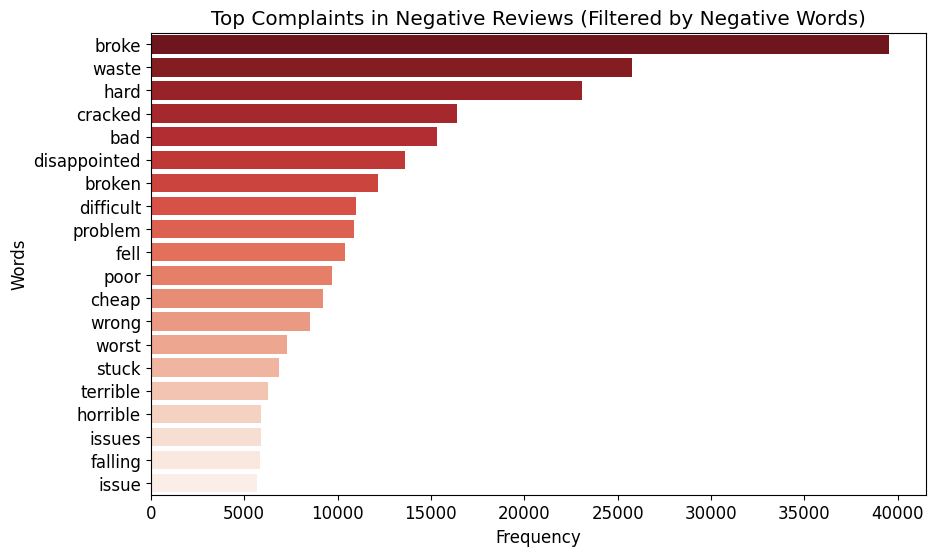

In [14]:
# Get a list of negative words from the lexicon
negative_words_set = set(opinion_lexicon.negative())

def filter_negative_words(text):
    """Filter only negative words from the text."""
    words = text.split()
    return [word.lower() for word in words if word.lower() in negative_words_set]

# Filter words to include only those with negative meanings
text = " ".join(merged_data[merged_data['sentiment_category'] == "Negative"]['text'].fillna(""))
filtered_words = filter_negative_words(text)

# Count the frequency of negative words
if filtered_words:
    word_counts = Counter(filtered_words)
    word_freq_df = pd.DataFrame(word_counts.items(), columns=['word', 'frequency']).sort_values(by='frequency', ascending=False)
    
    # Plot the top complaints with negative meanings
    plt.figure(figsize=(10, 6))
    sns.barplot(data=word_freq_df.head(20), x='frequency', y='word', palette='Reds_r')
    plt.title('Top Complaints in Negative Reviews (Filtered by Negative Words)')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.show()
else:
    print("No negative words found in the dataset.")

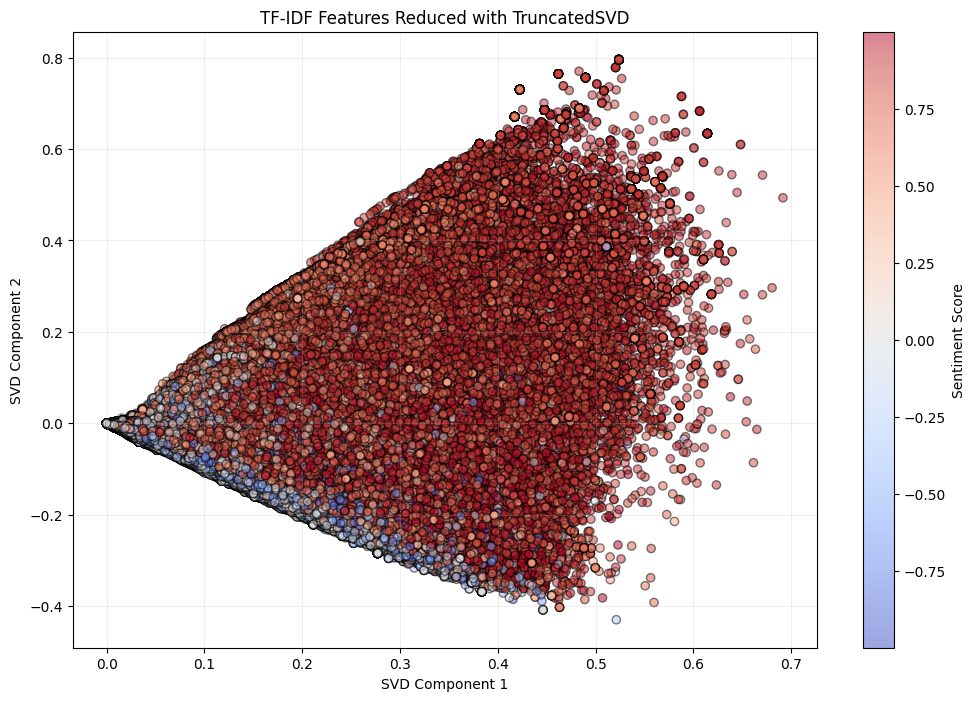

In [12]:
from sklearn.decomposition import TruncatedSVD

# Dimensionality Reduction with TruncatedSVD
svd = TruncatedSVD(n_components=2, random_state=42)
reduced_tfidf = svd.fit_transform(tfidf_matrix)

# Scatter Plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    reduced_tfidf[:, 0], reduced_tfidf[:, 1],
    c=merged_data['sentiment_score'], cmap='coolwarm', alpha=0.5, edgecolors='k'
)
plt.colorbar(scatter, label='Sentiment Score')
plt.title('TF-IDF Features Reduced with TruncatedSVD')
plt.xlabel('SVD Component 1')
plt.ylabel('SVD Component 2')
plt.grid(alpha=0.2)
plt.show()
